# Análisis Exploratorio de Datos: Dataset de Toxicidad en Comentarios

Este notebook realiza un análisis exploratorio detallado del dataset de toxicidad en comentarios, con el objetivo de entender las características de los datos y las relaciones entre las diferentes variables

## Importar bibliotecas necesaria

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import nltk
from nltk.corpus import stopwords

In [3]:
# Configuración de visualización
plt.style.use('fivethirtyeight')
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Descargar recursos de NLTK
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ibane\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ibane\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## =============================================================================
## 1. Carga y Exploración Inicial de Datos
## =============================================================================

In [4]:
# Cargar los datos
train_df = pd.read_csv('../data/raw/train.csv')
test_df = pd.read_csv('../data/raw/test.csv')

In [5]:
# Mostrar información básica
print("Forma del conjunto de entrenamiento:", train_df.shape)
print("Forma del conjunto de prueba:", test_df.shape)

Forma del conjunto de entrenamiento: (159571, 8)
Forma del conjunto de prueba: (153164, 2)


In [6]:
# Examinar las primeras filas
train_df.head()
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [7]:
# Información de tipos de datos
print("\nInformación del conjunto de entrenamiento:")
train_df.info()
print("\nInformación del conjunto de prueba:")
test_df.info()


Información del conjunto de entrenamiento:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB

Información del conjunto de prueba:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            153164 non-null  object
 1   comment_text  153164 non-null  object
dtypes: object(2)
memory usage: 2.3+ 

In [8]:
# Estadísticas descriptivas
print("\nEstadísticas descriptivas del conjunto de entrenamiento:")
train_df.describe(include='all')


Estadísticas descriptivas del conjunto de entrenamiento:


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571,159571,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
unique,159571,159571,NaN,NaN,NaN,NaN,NaN,NaN
top,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",NaN,NaN,NaN,NaN,NaN,NaN
freq,1,1,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,NaN,NaN,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [9]:
# Verificar valores nulos
print("\nValores nulos en el conjunto de entrenamiento:")
train_df.isnull().sum()
print("\nValores nulos en el conjunto de prueba:")
test_df.isnull().sum()


Valores nulos en el conjunto de entrenamiento:

Valores nulos en el conjunto de prueba:


id              0
comment_text    0
dtype: int64

## =============================================================================
## 2. Análisis de Etiquetas de Toxicidad
## =============================================================================

In [10]:
label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [11]:
# Distribución de etiquetas
label_counts = train_df[label_columns].sum().sort_values(ascending=False)
print("\nDistribución de las etiquetas:")
print(label_counts)


Distribución de las etiquetas:
toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


In [12]:
# Calcular porcentajes
total_comments = len(train_df)
label_percentages = (label_counts / total_comments * 100).round(2)
print("\nPorcentaje de comentarios por categoría:")
print(label_percentages)


Porcentaje de comentarios por categoría:
toxic            9.58
obscene          5.29
insult           4.94
severe_toxic     1.00
identity_hate    0.88
threat           0.30
dtype: float64


C:\Users\ibane\AppData\Local\Temp\ipykernel_14308\2865518305.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


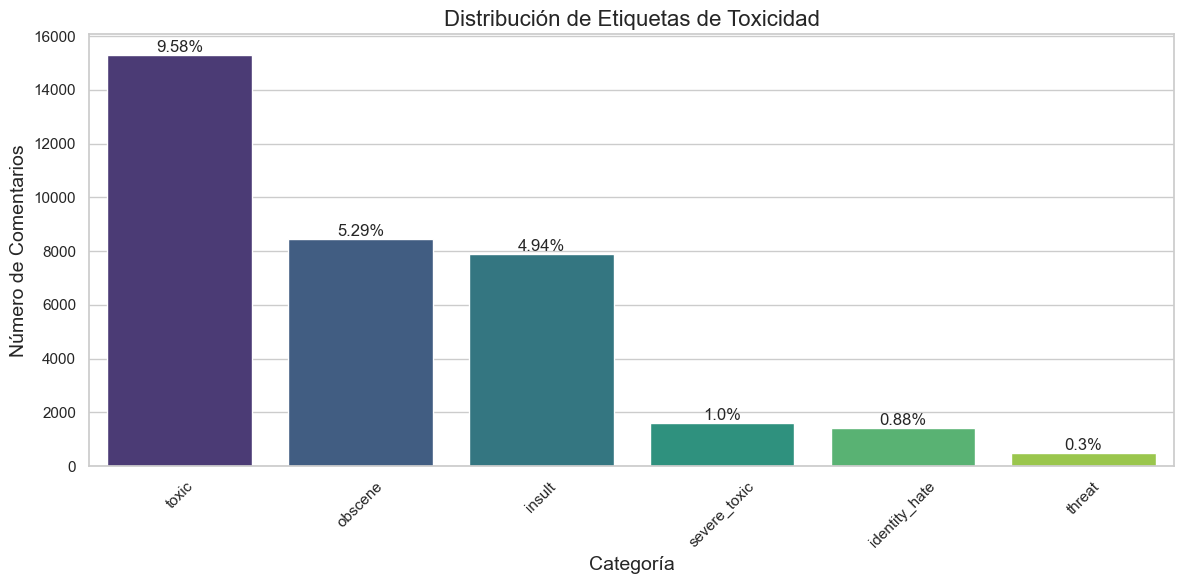

In [13]:
# Visualización de distribución
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Distribución de Etiquetas de Toxicidad', fontsize=16)
plt.ylabel('Número de Comentarios', fontsize=14)
plt.xlabel('Categoría', fontsize=14)
plt.xticks(rotation=45)

for i, p in enumerate(ax.patches):
    ax.annotate(f"{label_percentages.iloc[i]}%", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom', fontsize=12)
plt.tight_layout()
plt.savefig('../reports/label_distribution_detailed.png')
plt.show()

In [14]:
# Análisis de múltiples etiquetas
train_df['num_labels'] = train_df[label_columns].sum(axis=1)
label_count_distribution = train_df['num_labels'].value_counts().sort_index()
print("\nDistribución de número de etiquetas por comentario:")
print(label_count_distribution)

label_count_percentages = (label_count_distribution / total_comments * 100).round(2)
print("\nPorcentaje de comentarios por número de etiquetas:")
print(label_count_percentages)


Distribución de número de etiquetas por comentario:
num_labels
0    143346
1      6360
2      3480
3      4209
4      1760
5       385
6        31
Name: count, dtype: int64

Porcentaje de comentarios por número de etiquetas:
num_labels
0    89.83
1     3.99
2     2.18
3     2.64
4     1.10
5     0.24
6     0.02
Name: count, dtype: float64


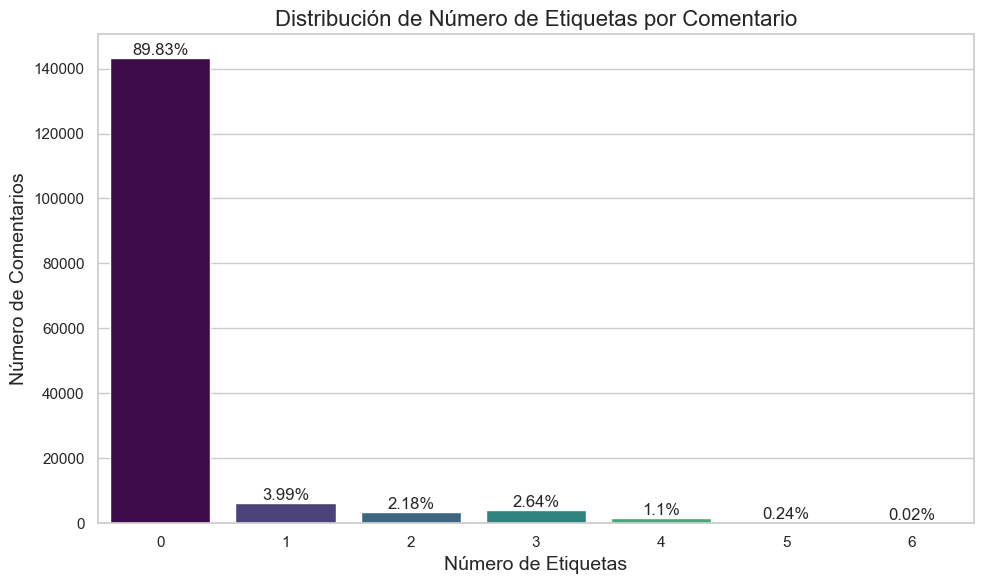

In [15]:
# Visualización de conteo de etiquetas
plt.figure(figsize=(10, 6))
# Updated barplot to avoid FutureWarning
ax = sns.barplot(x=label_count_distribution.index, 
                y=label_count_distribution.values, 
                hue=label_count_distribution.index,  # Add hue parameter
                palette='viridis',
                legend=False)  # Hide the legend since it's redundant
plt.title('Distribución de Número de Etiquetas por Comentario', fontsize=16)
plt.ylabel('Número de Comentarios', fontsize=14)
plt.xlabel('Número de Etiquetas', fontsize=14)

for i, p in enumerate(ax.patches):
    ax.annotate(f"{label_count_percentages.iloc[i]}%", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom', fontsize=12)
plt.tight_layout()
plt.savefig('../reports/label_count_distribution.png')
plt.show()

## =============================================================================
## 3. Análisis de Correlación entre Etiquetas
## =============================================================================

In [16]:
# Matriz de correlación
correlation_matrix = train_df[label_columns].corr()
print("Matriz de correlación entre etiquetas:")
print(correlation_matrix)

Matriz de correlación entre etiquetas:
                  toxic  severe_toxic   obscene    threat    insult  \
toxic          1.000000      0.308619  0.676515  0.157058  0.647518   
severe_toxic   0.308619      1.000000  0.403014  0.123601  0.375807   
obscene        0.676515      0.403014  1.000000  0.141179  0.741272   
threat         0.157058      0.123601  0.141179  1.000000  0.150022   
insult         0.647518      0.375807  0.741272  0.150022  1.000000   
identity_hate  0.266009      0.201600  0.286867  0.115128  0.337736   

               identity_hate  
toxic               0.266009  
severe_toxic        0.201600  
obscene             0.286867  
threat              0.115128  
insult              0.337736  
identity_hate       1.000000  


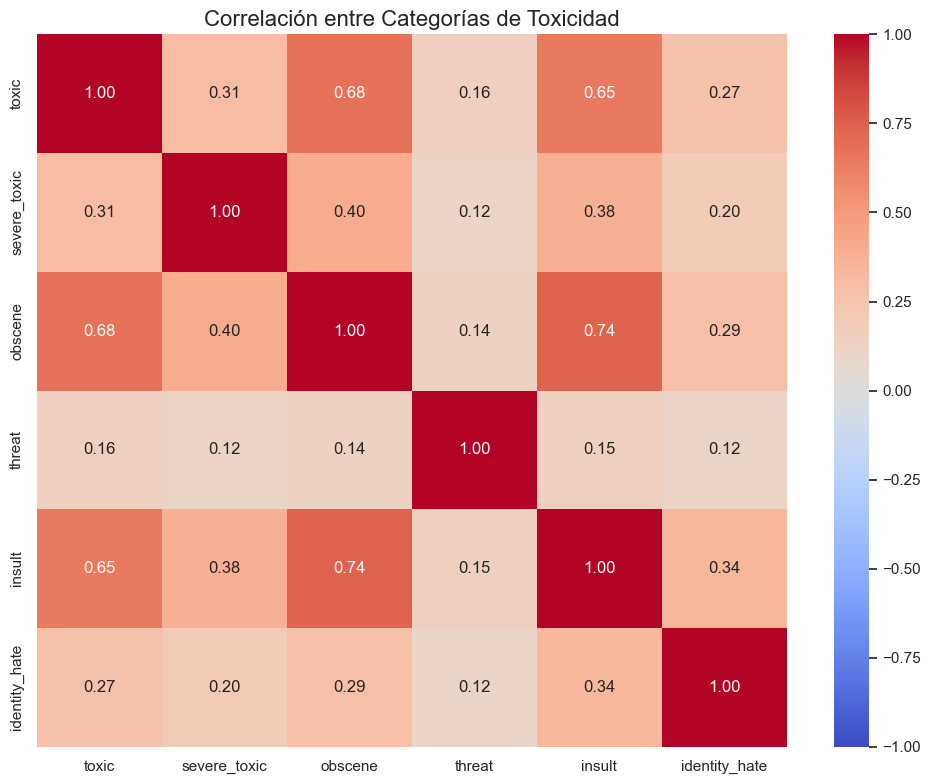

In [18]:
# Visualización de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlación entre Categorías de Toxicidad', fontsize=16)
plt.tight_layout()
plt.savefig('../reports/label_correlation.png')
plt.show()

In [19]:
# Matriz de co-ocurrencia
co_occurrence = pd.DataFrame(index=label_columns, columns=label_columns)
for i in label_columns:
    for j in label_columns:
        co_occurrence.loc[i, j] = ((train_df[i] == 1) & (train_df[j] == 1)).sum()
print("Matriz de co-ocurrencia de etiquetas:")
print(co_occurrence)

Matriz de co-ocurrencia de etiquetas:
               toxic severe_toxic obscene threat insult identity_hate
toxic          15294         1595    7926    449   7344          1302
severe_toxic    1595         1595    1517    112   1371           313
obscene         7926         1517    8449    301   6155          1032
threat           449          112     301    478    307            98
insult          7344         1371    6155    307   7877          1160
identity_hate   1302          313    1032     98   1160          1405


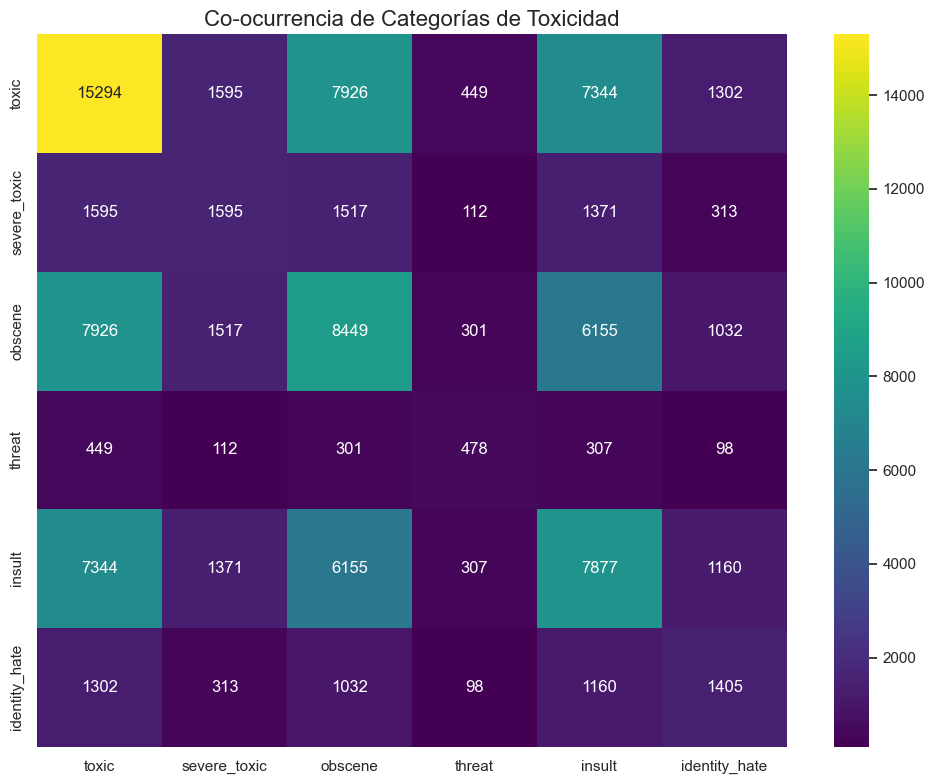

In [22]:
# Visualización de co-ocurrencia
plt.figure(figsize=(10, 8))

co_occurrence_numeric = co_occurrence.astype(float)

sns.heatmap(co_occurrence_numeric, annot=True, cmap='viridis', fmt='.0f')
plt.title('Co-ocurrencia de Categorías de Toxicidad', fontsize=16)
plt.tight_layout()
plt.savefig('../reports/label_cooccurrence.png')
plt.show()

## =============================================================================
## 4. Análisis de Longitud de Comentarios
## =============================================================================

In [23]:
# Calcular longitud
train_df['comment_length'] = train_df['comment_text'].apply(len)
test_df['comment_length'] = test_df['comment_text'].apply(len)

In [24]:
# Estadísticas de longitud
print("Estadísticas de longitud de comentarios (entrenamiento):")
print(train_df['comment_length'].describe())
print("\nEstadísticas de longitud de comentarios (prueba):")
print(test_df['comment_length'].describe())

Estadísticas de longitud de comentarios (entrenamiento):
count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: comment_length, dtype: float64

Estadísticas de longitud de comentarios (prueba):
count    153164.000000
mean        364.875121
std         592.492099
min           1.000000
25%          79.000000
50%         180.000000
75%         392.000000
max        5000.000000
Name: comment_length, dtype: float64


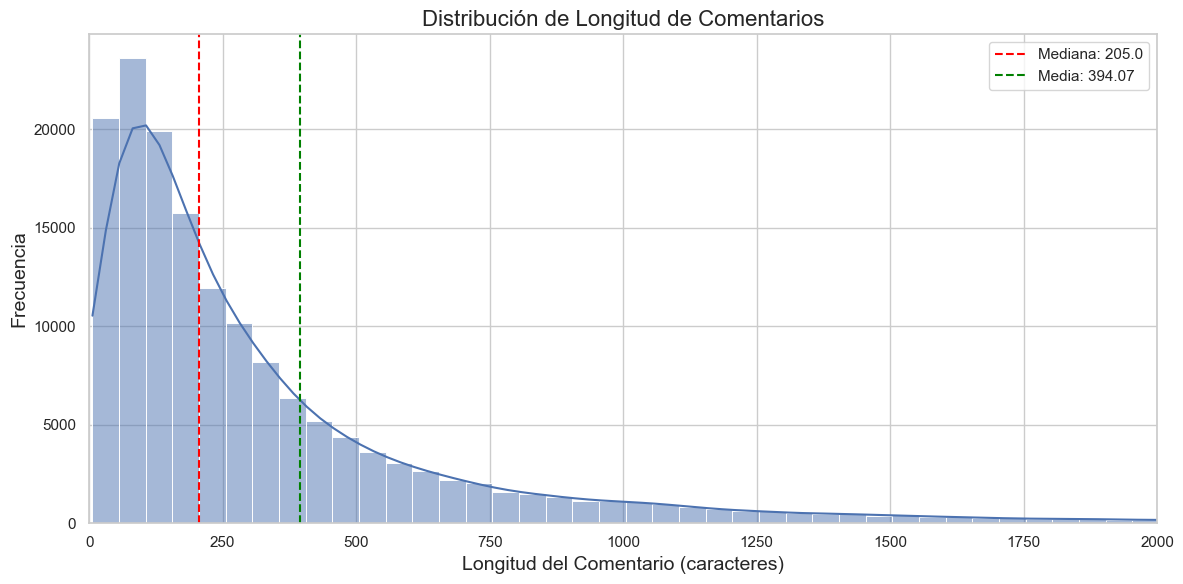

In [25]:
#Visualizar la distribución de longitud de comentarios
plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x='comment_length', bins=100, kde=True)
plt.title('Distribución de Longitud de Comentarios', fontsize=16)
plt.xlabel('Longitud del Comentario (caracteres)', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.xlim(0, 2000)
plt.axvline(x=train_df['comment_length'].median(), color='red', linestyle='--', label=f'Mediana: {train_df["comment_length"].median()}')
plt.axvline(x=train_df['comment_length'].mean(), color='green', linestyle='--', label=f'Media: {train_df["comment_length"].mean():.2f}')
plt.legend()
plt.tight_layout()
plt.savefig('../reports/comment_length_overall.png')
plt.show()

In [32]:
# Función para limpiar y tokenizar texto
def clean_and_tokenize(text):
    # Convertir a minúsculas y eliminar caracteres especiales
    text = re.sub(r'[^\w\s]', '', str(text).lower())
    # Tokenizar
    tokens = text.split()
    # Eliminar stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return tokens

In [33]:
# Analizar palabras más comunes en comentarios tóxicos y no tóxicos
toxic_comments = train_df[train_df['toxic'] == 1]['comment_text']
non_toxic_comments = train_df[train_df['toxic'] == 0]['comment_text']

toxic_words = []
for comment in toxic_comments:
    toxic_words.extend(clean_and_tokenize(comment))

non_toxic_words = []
for comment in non_toxic_comments:
    non_toxic_words.extend(clean_and_tokenize(comment))

In [34]:
# Contar frecuencias
toxic_word_counts = Counter(toxic_words).most_common(20)
non_toxic_word_counts = Counter(non_toxic_words).most_common(20)

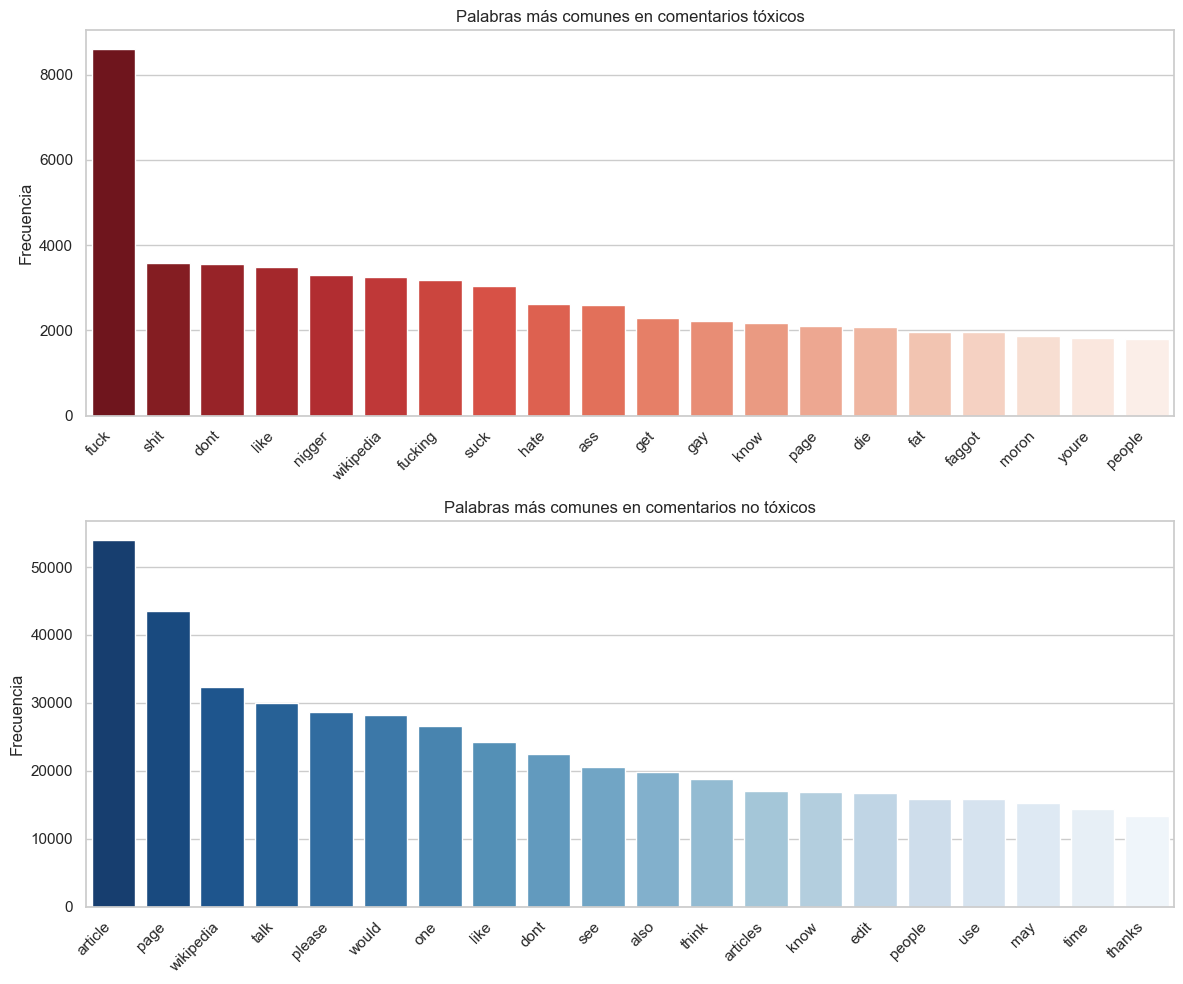

In [37]:
# Visualizar palabras más comunes
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
sns.barplot(x=[word[0] for word in toxic_word_counts], 
            y=[word[1] for word in toxic_word_counts],
            hue=[word[0] for word in toxic_word_counts],
            palette='Reds_r',
            legend=False)
plt.title('Palabras más comunes en comentarios tóxicos')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Frecuencia')

plt.subplot(2, 1, 2)
sns.barplot(x=[word[0] for word in non_toxic_word_counts], 
            y=[word[1] for word in non_toxic_word_counts],
            hue=[word[0] for word in non_toxic_word_counts],
            palette='Blues_r',
            legend=False)
plt.title('Palabras más comunes en comentarios no tóxicos')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.savefig('../reports/common_words.png')
plt.show()

In [38]:
# Crear nubes de palabras
plt.figure(figsize=(16, 8))

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

In [39]:
# Convertir las listas de palabras a diccionarios para la nube de palabras
toxic_word_dict = dict(toxic_word_counts)
non_toxic_word_dict = dict(non_toxic_word_counts)

(np.float64(-0.5), np.float64(799.5), np.float64(399.5), np.float64(-0.5))

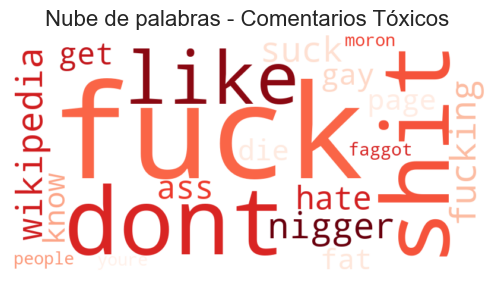

In [40]:
# Nube de palabras para comentarios tóxicos
plt.subplot(1, 2, 1)
wordcloud_toxic = WordCloud(width=800, height=400, 
                           background_color='white',
                           max_words=100,
                           colormap='Reds',
                           contour_width=1, 
                           contour_color='black')
wordcloud_toxic.generate_from_frequencies(toxic_word_dict)
plt.imshow(wordcloud_toxic, interpolation='bilinear')
plt.title('Nube de palabras - Comentarios Tóxicos', fontsize=16)
plt.axis('off')

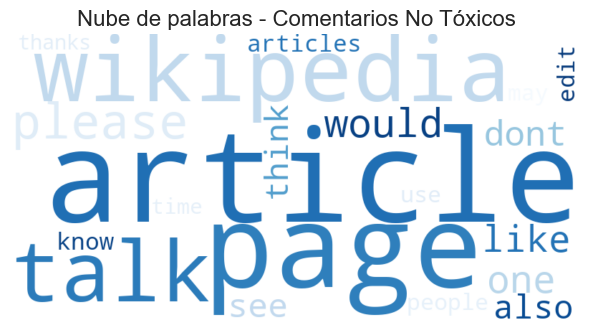

In [41]:
# Nube de palabras para comentarios no tóxicos
plt.subplot(1, 2, 2)
wordcloud_non_toxic = WordCloud(width=800, height=400, 
                               background_color='white',
                               max_words=100,
                               colormap='Blues',
                               contour_width=1, 
                               contour_color='black')
wordcloud_non_toxic.generate_from_frequencies(non_toxic_word_dict)
plt.imshow(wordcloud_non_toxic, interpolation='bilinear')
plt.title('Nube de palabras - Comentarios No Tóxicos', fontsize=16)
plt.axis('off')

plt.tight_layout()
plt.savefig('../reports/word_clouds.png')
plt.show()